# Running Dask on AzureML

You may need torun source activate azureml_py36 && pip install dask distributed...

Let's import some stuff

In [2]:
import os, socket
from azureml.core import Workspace, Experiment
from azureml.widgets import RunDetails
from azureml.core.runconfig import RunConfiguration, MpiConfiguration
from azureml.train.estimator import Estimator
from azureml.core.compute import ComputeTarget, AmlCompute

## Get the workspace

In [4]:
ws = Workspace.from_config()
ws

Workspace.create(name='ncus-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')

## Create an Azure ML cluster

In [17]:
if 'dask-cluster' not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    # final default values for blog tbd - need to benchmark and minimize cost
    config = AmlCompute.provisioning_configuration(
             vm_size                 = 'STANDARD_DS15_V2',
             max_nodes               = 100,
             admin_username          = 'daskuser',
             admin_user_password     = 'password',
             vnet_resourcegroup_name = ws.resource_group,
             vnet_name               = 'dask-vnet',
             subnet_name             = 'default'
    )
    
    ct = ComputeTarget.create(ws, 'dask-cluster', config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets['dask-cluster']
    
ct

AmlCompute(workspace=Workspace.create(name='ncus-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg'), name=dask-cluster, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copetersrg/providers/Microsoft.MachineLearningServices/workspaces/ncus-azureml/computes/dask-cluster, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## Create a Dataset

In [18]:
if 'weather-files' not in ws.datasets:
    ds = Dataset.File.from_files('https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet', validate=False)
    ds = ds.register(ws, 'weather-files')
else:
    ds = ws.datasets['weather-files']
    
ds

{
  "source": [
    "https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet"
  ],
  "definition": [
    "GetFiles"
  ],
  "registration": {
    "id": "c0fe2407-f46d-4462-b993-f23ed423bd15",
    "name": "weather-files",
    "version": 1,
    "workspace": "Workspace.create(name='ncus-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')"
  }
}

## Start the run

The below 2 cells submit the run to the Azure ML cluster and monitor its status. Depending on your compute target and `environment.yaml` the setup time may vary. The second cell launches a widget to monitor the run. Soon after the run's status is 'Running' the setup for using the cluster in a Dask Client is performed with necessary information logged to the run. This will show up in the widget and run details page in the studio.

The widget gets stuck a lot, refresh it if the duration is not increasing.

![Run widget](media/run-widget.png)

In [19]:
est = Estimator('dask', 
                compute_target=ct, 
                entry_script='startDask.py', 
                conda_dependencies_file='environment.yml', 
                script_params={'--datastore': ws.get_default_datastore()},
                inputs=[ds.as_named_input('weather').as_download('/tmp/noaa')],
                node_count=10,
                distributed_training=MpiConfiguration())

#run = next(ws.experiments['dask'].get_runs()) # uncomment to get existing run (if kernel restarted, etc)
run = Experiment(ws, 'dask').submit(est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask,dask_1576872879_6afa8e64,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [23]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

## Wait

Wait for the cluster to spin up, the run to start, and the `startDask.py` process complete. At this point, information needed for connecting the cluster will be logged back to the run.

The below cell waits for that information to be logged to the run, sets up port forwarding for the Dask dashboard, and prints the url. Make sure to check out the dashboard as you run through the rest of the notebook! 

In [24]:
import time
from IPython.display import clear_output

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'headnode' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

clear_output()

ci_port = 9798

if run.get_status() == 'Canceled':
    print('Run was canceled')
else:
    dashboard_url = 'https://{}-{}.{}.instances.azureml.net/status'.format(socket.gethostname(), ci_port, ws.get_details()['location'])
    run.log('dashboard_url', dashboard_url) if 'dashboard_url' not in run.get_metrics() else 0

    cmd = f'setsid socat tcp-listen:{ci_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &'
    print(f'Setting up port forwarding: {cmd}')
    os.system(cmd)
    print(f'Cluster is ready to use and dashboard can be viewed at {dashboard_url}.')

Setting up port forwarding: setsid socat tcp-listen:9798,reuseaddr,fork tcp:10.1.0.20:8787 &
Cluster is ready to use and dashboard can be viewed at https://instance2-9798.northcentralus.instances.azureml.net/status.


## Dask dashboard

Please don't miss the dashboard.

In [25]:
print(dashboard_url)

https://instance2-9798.northcentralus.instances.azureml.net/status


## Dashboard blank?

Do you see the 'Status', 'Workers', etc. at the top but the rest of the page is blank? Open up a terminal. Edit the nginx config file to remove the '/' after 'ws' near 'websocket'. Then restart the service.

```
sudo vi /etc/nginx/nginx.conf
sudo service nginx restart
```

## Connect to cluster through Dask Client

In [26]:
import dask
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

c = Client(f'tcp://{run.get_metrics()["scheduler"]}')
c.restart()
c

Client Scheduler: tcp://10.1.0.20:8786 Dashboard: http://10.1.0.20:8787/status,Cluster Workers: 10 Cores: 200 Memory: 1.48 TB


## Have fun

Go try out any of the [dask examples](https://github.com/dask/dask-examples). You'll need to connect to the client from any other notebook you run. Or continue below running what I have so far for using the dataset. 

In [27]:
import glob

files = dask.delayed(glob.glob)('/tmp/noaa/**/*.parquet', recursive=True).compute()
#files

In [28]:
df = dd.from_delayed([dask.delayed(pd.read_parquet)(file) for file in files])

In [29]:
df.npartitions

144

In [30]:
#df = df.repartition(npartitions=10*df.npartitions)
#df.npartitions

In [31]:
#df = df.persist()

In [32]:
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,999999,25711,2019-01-01 00:00:00,57.158,-170.212,6.0,NaN,4.1,2.8,NaN,...,NaN,1.0,0.0,NaN,ST. PAUL 4 NE,US,999999-25711,2019,1,1.0
1,724170,13729,2019-01-09 07:51:00,38.885,-79.853,603.0,290.0,5.7,2.2,1013.3,...,NaN,1.0,0.0,NaN,ELKINS-RAND CO-J.RAND FIELD AIRPORT,US,724170-13729,2019,9,1.0
2,999999,25711,2019-01-01 00:05:00,57.158,-170.212,6.0,NaN,NaN,2.9,NaN,...,NaN,NaN,NaN,NaN,ST. PAUL 4 NE,US,999999-25711,2019,1,1.0
3,724170,13729,2019-01-09 08:51:00,38.885,-79.853,603.0,260.0,5.1,2.2,1012.2,...,NaN,1.0,0.0,NaN,ELKINS-RAND CO-J.RAND FIELD AIRPORT,US,724170-13729,2019,9,1.0
4,999999,25711,2019-01-01 00:10:00,57.158,-170.212,6.0,NaN,NaN,2.9,NaN,...,NaN,NaN,NaN,NaN,ST. PAUL 4 NE,US,999999-25711,2019,1,1.0


In [33]:
df.npartitions

144

In [35]:
%time len(df)

CPU times: user 435 ms, sys: 28.1 ms, total: 463 ms
Wall time: 22.5 s


1396216646

In [36]:
df.datetime = dd.to_datetime(df.datetime).dt.floor('d')

In [37]:
#df = df.set_index(df.datetime, sorted=False).persist()

In [38]:
#%time len(df)

## Check out the graph on this bad boy

![Describe graph](media/describe-graph.png)

In [39]:
df.describe().compute()

,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.396217e+09,1.396217e+09,1.396217e+09,1.121423e+09,1.164553e+09,1.370989e+09,4.935403e+08,1.262732e+08,5.196196e+07,2.935522e+08,2.935522e+08,7.996754e+06,1.396217e+09,1.396217e+09,1.396217e+09
mean,3.743921e+01,-3.926299e+01,3.969070e+02,1.651349e+02,3.437453e+00,1.202833e+01,1.014650e+03,2.964050e+01,4.272739e+00,9.340661e+00,1.059272e+03,1.823921e+01,2.013765e+03,1.568660e+01,1.000000e+00
std,2.156708e+01,7.856501e+01,6.091156e+02,1.145395e+02,2.863989e+00,1.247015e+01,9.356271e+00,2.925401e+01,2.998545e+00,2.016060e+01,3.062605e+03,3.396985e+01,3.406793e+00,8.809036e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.405000e+01,-9.120000e+01,5.000000e+01,8.000000e+01,2.000000e+00,8.500000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,4.170600e+01,-5.096500e+01,2.090000e+02,1.900000e+02,3.600000e+00,1.610000e+01,1.017200e+03,4.900000e+01,6.000000e+00,3.000000e+00,0.000000e+00,1.500000e+01,2.016000e+03,1.600000e+01,1.000000e+00
75%,4.922000e+01,2.136700e+01,5.490000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.026000e+03,7.100000e+01,8.000000e+00,2.400000e+01,9.999000e+03,6.300000e+01,2.019000e+03,2.400000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.019000e+03,3.100000e+01,1.000000e+00


In [40]:
means = df.groupby(df.datetime).mean().compute()
means.head()

,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2019-01-01,36.330089,-40.093471,394.528787,187.705747,4.006728,4.387063,1017.184036,40.861789,4.295040,15.433440,2282.893454,14.632568,2019.0,1.0,1.0
2019-01-02,36.417239,-40.479066,386.723336,172.045272,3.495339,3.257260,1018.305155,42.345057,4.646093,15.000469,2260.395487,16.692365,2019.0,2.0,1.0
2019-01-03,36.288058,-40.401202,386.625893,174.970799,3.363909,4.124152,1017.696414,43.796744,4.553081,14.267187,2176.465576,17.134310,2019.0,3.0,1.0
2019-01-04,36.354498,-40.115916,383.447838,177.302155,3.284081,4.949043,1016.061184,40.644774,4.571939,14.804659,2235.106972,17.278669,2019.0,4.0,1.0
2019-01-05,36.455005,-40.022807,387.493090,179.998570,3.137902,4.762165,1015.726664,38.654369,4.646371,15.413138,2248.486032,19.317032,2019.0,5.0,1.0


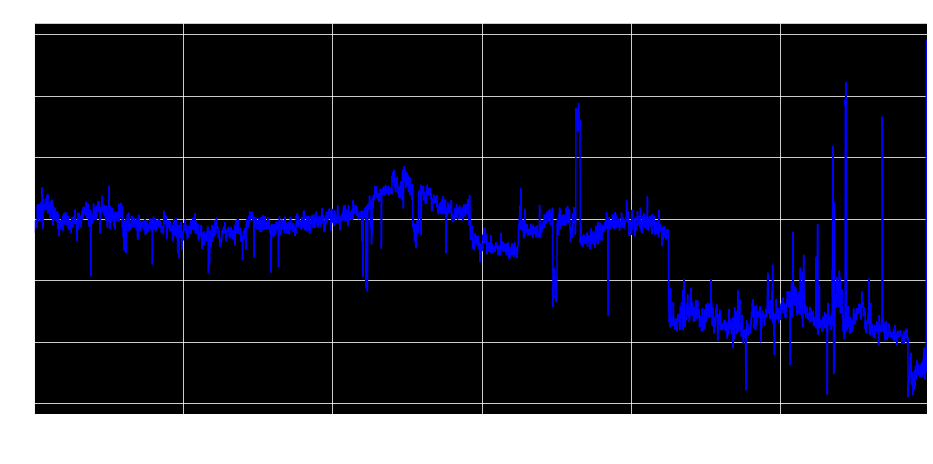

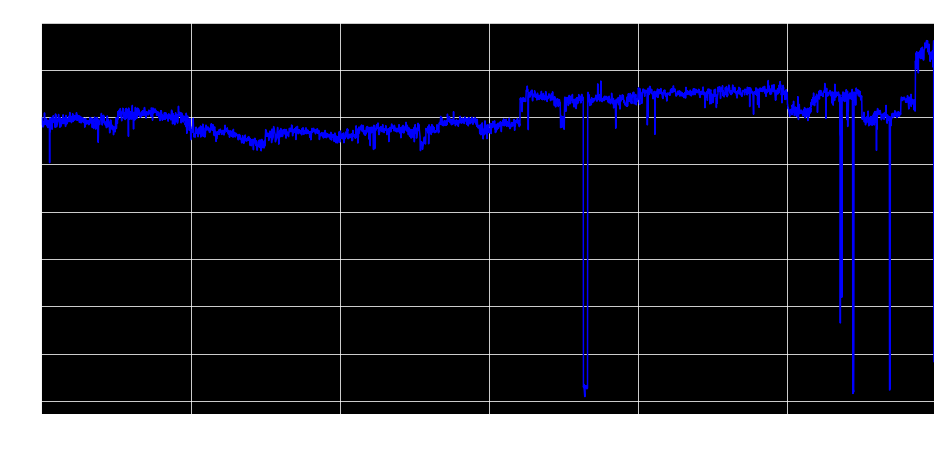

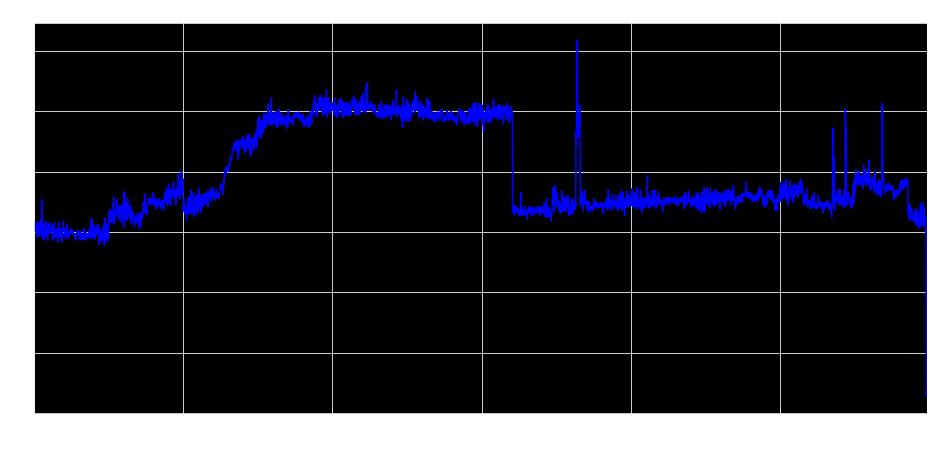

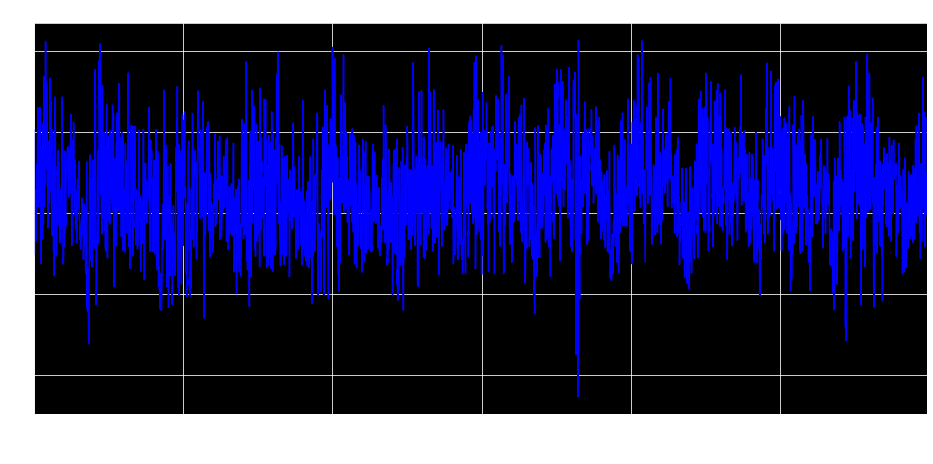

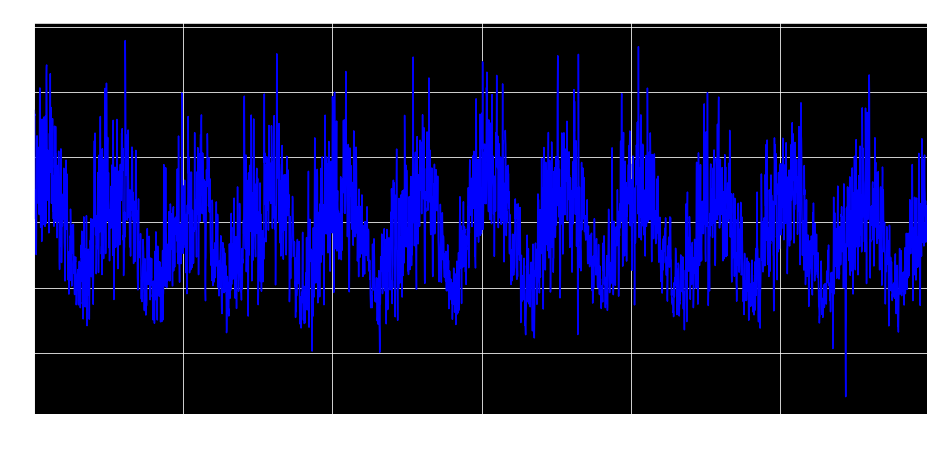

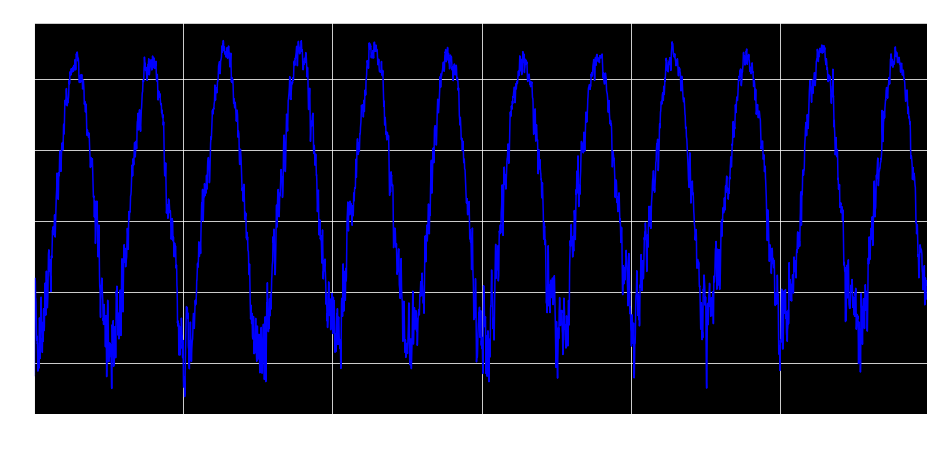

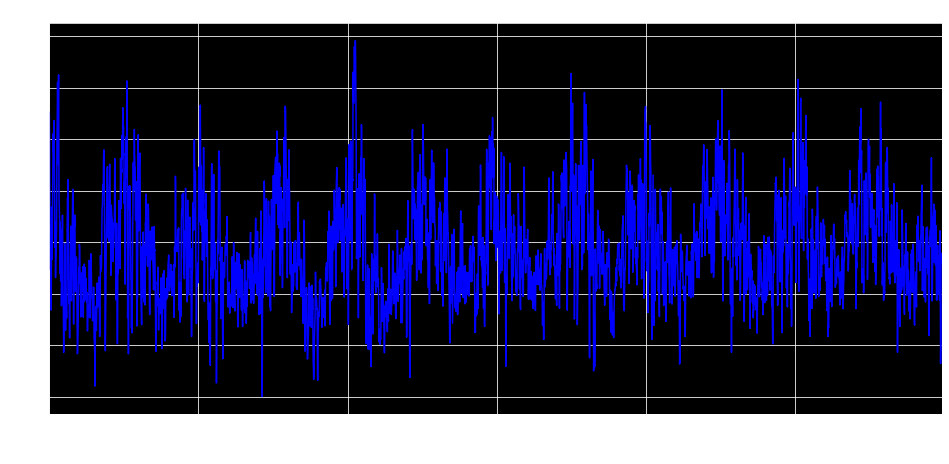

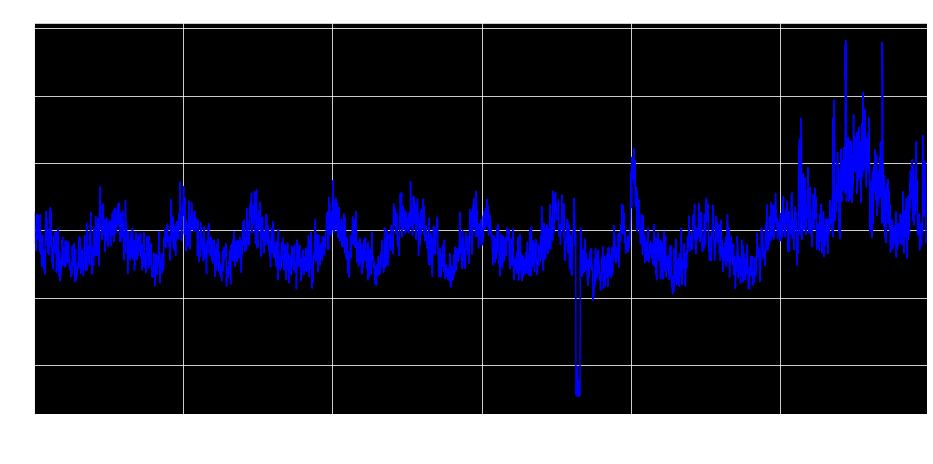

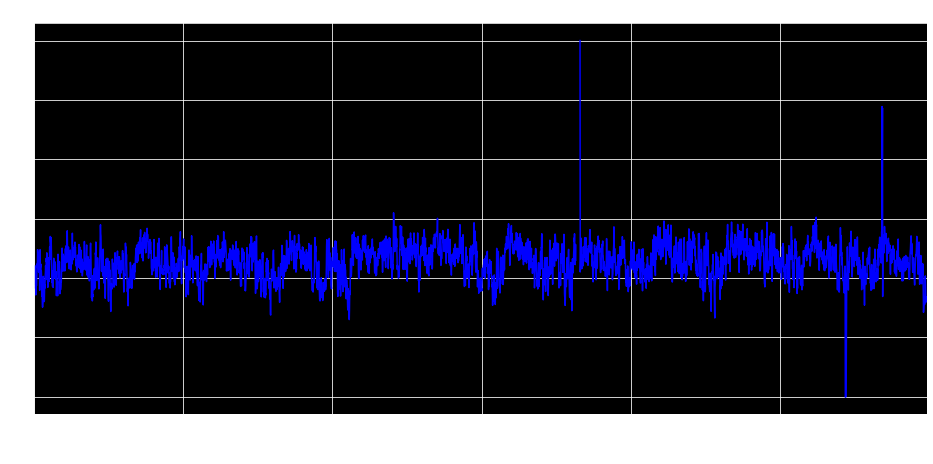

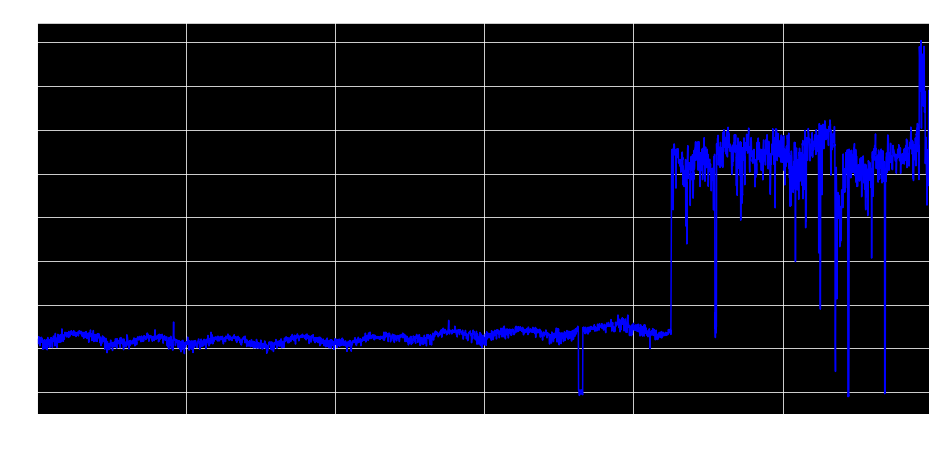

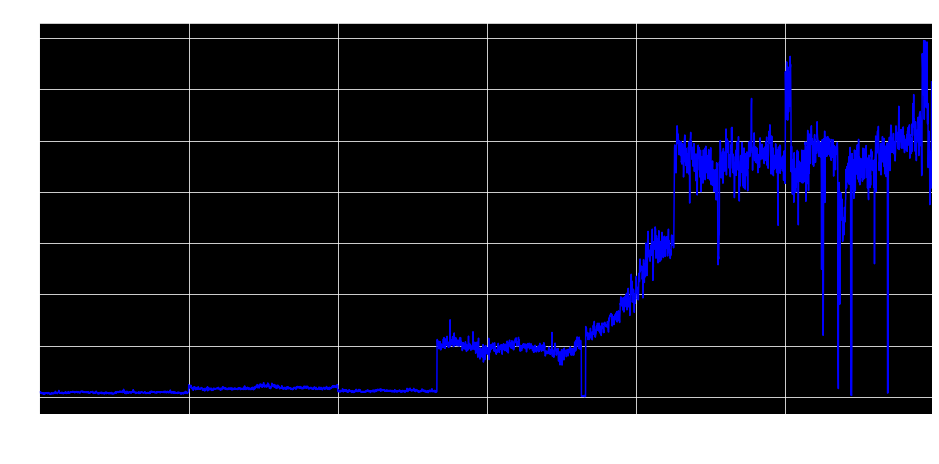

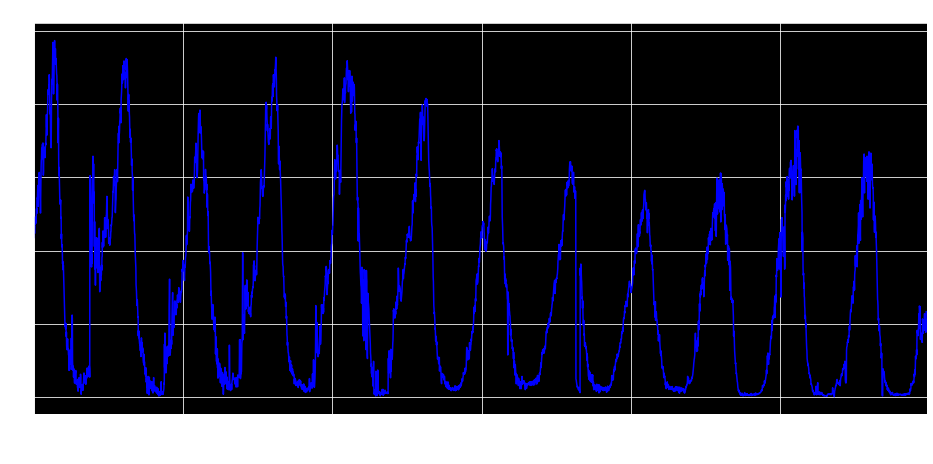

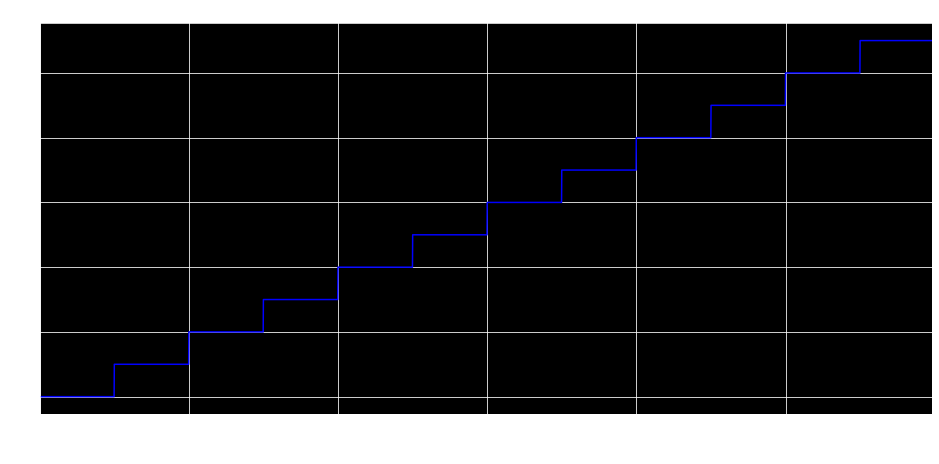

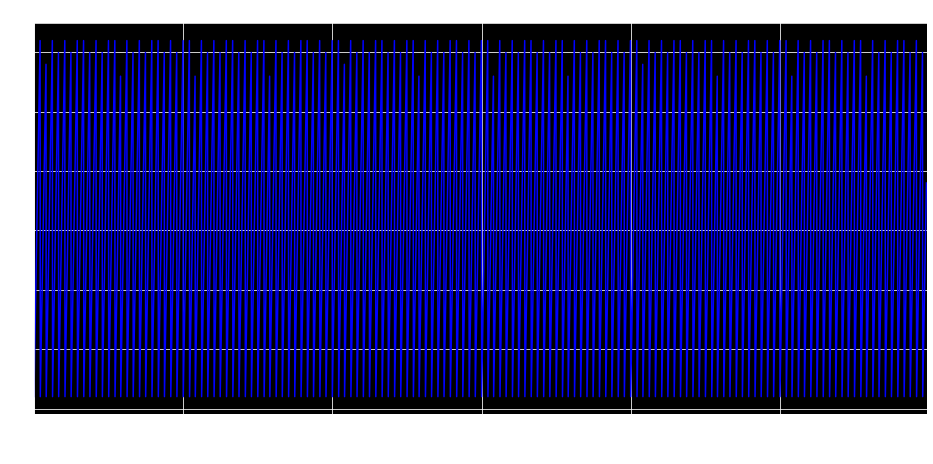

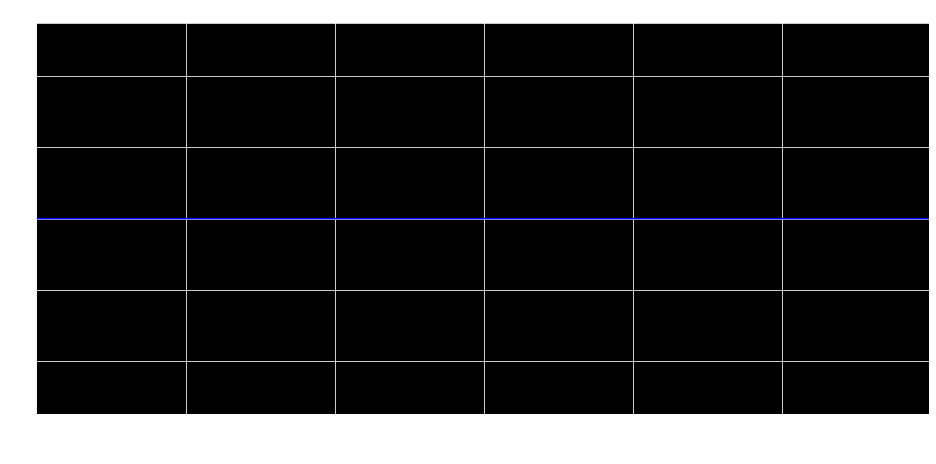

Exception in thread Thread-69:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/azureml_py36/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/envs/azureml_py36/lib/python3.6/multiprocessing/pool.py", line 479, in _handle_results
    cache[job]._set(i, obj)
  File "/anaconda/envs/azureml_py36/lib/python3.6/multiprocessing/pool.py", line 649, in _set
    self._callback(self._value)
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/widgets/_userrun/_run_details.py", line 552, in _update_metrics
    self.widget_instance.run_metrics = result
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notif

In [43]:
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

%matplotlib inline 

for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime.now()])
    plt.grid()
    
    run.log_image(col, plot=plt)

In [ ]:
df = df.drop(['datetime'], axis=1)

In [ ]:
df.index

In [ ]:
def write_data(path):
    df.to_parquet(path)

In [ ]:
a = dask.delayed(write_data)(ds+'/dask/outputs/isd').compute()

In [ ]:
counts = df.groupby([df.index.month, df.index.year]).day.count().compute()

In [ ]:
cs = [counts[month][2015] for month in range(1, 13)]
cs

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2015, 1, 1), datetime(2015, 12, 1)])
    plt.grid()
    
    run.log_image(col, plot=plt)

In [ ]:
df.memory_usage(index=True, deep=True).sum().compute()

In [ ]:
df.info()

See if the cluster works

In [ ]:
import time
import numpy as np
from dask import delayed, visualize

def inc(x):
    time.sleep(abs(np.random.normal(5, 2)))
    return x + 1

fut = []
for i in range(10):
    fut.append( c.submit(delayed(inc), i) )

fut

In [ ]:
for i in fut:
    print(i.result())

In [ ]:
def sum(a):
    x = 0
    for y in a:
        x += y
    return x

results = []
for f in fut:
    results.append(f.result())
    
fut2 = c.submit(sum, results)
fut2

In [ ]:
fut2.result().compute()

In [ ]:
visualize(fut2.result())

# Training on Large Datasets
(from https://github.com/dask/dask-tutorial)

Sometimes you'll want to train on a larger than memory dataset. `dask-ml` has implemented estimators that work well on dask arrays and dataframes that may be larger than your machine's RAM.

In [ ]:
from dask.distributed import Client
import joblib
import dask.array as da
import dask.delayed
from sklearn.datasets import make_blobs
import numpy as np

We'll make a small (random) dataset locally using scikit-learn.

In [ ]:
n_centers = 12
n_features = 20

X_small, y_small = make_blobs(n_samples=1000, centers=n_centers, n_features=n_features, random_state=0)

centers = np.zeros((n_centers, n_features))

for i in range(n_centers):
    centers[i] = X_small[y_small == i].mean(0)
    
centers[:4]

The small dataset will be the template for our large random dataset.
We'll use `dask.delayed` to adapt `sklearn.datasets.make_blobs`, so that the actual dataset is being generated on our workers. 

In [ ]:
n_samples_per_block = 200000
n_blocks = 500

delayeds = [dask.delayed(make_blobs)(n_samples=n_samples_per_block,
                                     centers=centers,
                                     n_features=n_features,
                                     random_state=i)[0]
            for i in range(n_blocks)]
arrays = [da.from_delayed(obj, shape=(n_samples_per_block, n_features), dtype='float64')
          for obj in delayeds]
X = da.concatenate(arrays)
X

In [ ]:
# Check the size of the array
X.nbytes / 1e9

In [ ]:
# Only run this on the cluster.
X = X.persist()  

The algorithms implemented in Dask-ML are scalable. They handle larger-than-memory datasets just fine.

They follow the scikit-learn API, so if you're familiar with scikit-learn, you'll feel at home with Dask-ML.

In [ ]:
from dask_ml.cluster import KMeans
clf = KMeans(init_max_iter=3, oversampling_factor=10)

In [ ]:
%time clf.fit(X)

In [ ]:
clf.labels_

In [ ]:
clf.labels_[:10].compute()

## Shut cluster down
To shut the cluster down, cancel the job that runs the cluster. 

In [ ]:
for run in ws.experiments['dask'].get_runs():
    if run.get_status() == "Running":
        print(f'cancelling run {run.id}')
        run.cancel()

### Just for convenience, get the latest running Run

In [ ]:
for run in ws.experiments['dask'].get_runs():
    if run.get_status() == "Running":
        print(f'latest running run is {run.id}')
        break